<center>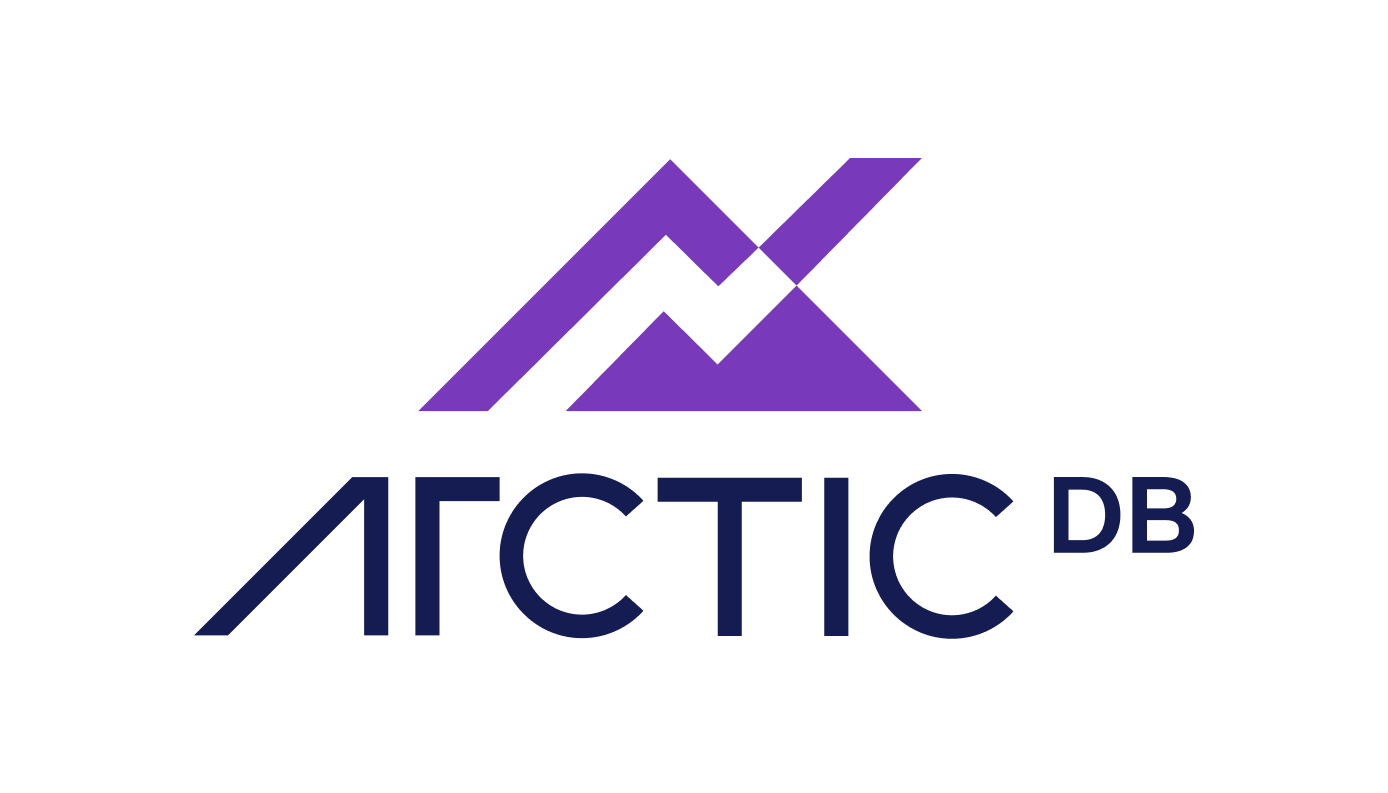
</center>

# Loading AWS Bitcoin blockchain data into ArcticDB, using AWS as storage

### In this demo, we illustrate how to use AWS with ArcticDB. We are going to
* Set up AWS access
* Initialise ArcticDB with AWS as storage
* Read a section of the Bitcoin blockchain from an AWS public dataset
* Store the data in ArcticDB
* Read the data back
* Perform a simple analysis on the data

Note: This is set up to run on Google colab. It will need some simple changes to remove the Google drive code to run in other enviroments

<hr />

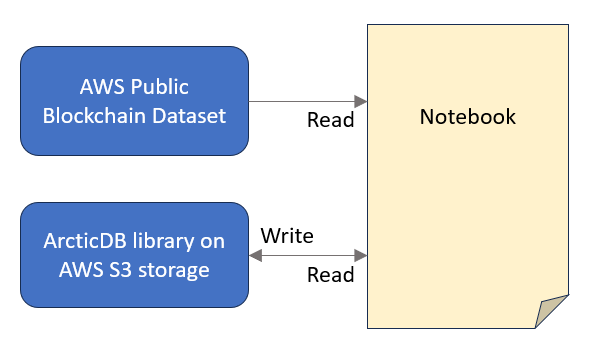

### Install ArcticDB and S3 libraries

In [ ]:
# s3fs is used by pandas.read_parquet('s3://...')
%pip install arcticdb boto3 tqdm s3fs fastparquet

### Imports

In [2]:
import os
from uuid import uuid4
from datetime import timedelta, datetime
from tqdm import tqdm
import boto3
import numpy as np
import pandas as pd
from botocore import UNSIGNED
from botocore.client import Config
import arcticdb as adb
from google.colab import drive, userdata

### Read or Create AWS config

In [3]:
# mount Google Drive for the config file to live on
drive.mount('/content/drive')
path = '/content/drive/MyDrive/config/awscli.ini'
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
check = boto3.session.Session()
no_config = check.get_credentials() is None or check.region_name is None

if no_config:
    print('*'*40)
    print('Setup your AWS S3 credentials and region before continuing.')
    print('https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html')
    print('*'*40)

#### Create a config file
* You should only need to run this section once
* Enter your AWS details below and change `write_aws_config_file` to True
* Future runs can pick up the config file you have save in your Drive

In [5]:
aws_access_key = "my_access_key"
aws_secret_access_key = "my_secret_access_key"
region = "my_region"

config_text = f"""
[default]
aws_access_key_id = {aws_access_key}
aws_secret_access_key = {aws_secret_access_key}
region = {region}
"""

write_aws_config_file = False
if write_aws_config_file:
    with open(path, 'w') as f:
        f.write(text)

### Set up the AWS bucket
* First check for existing buckets to use
* Set up a new bucket if there are no suitable existing ones

In [6]:
s3 = boto3.resource('s3')
region = boto3.session.Session().region_name

bucket = [b for b in s3.buckets.all() if b.name.startswith('arcticdb-data-')]

if bucket:
    bucket_name = bucket[0].name
    print('Bucket found:', bucket_name)
else:
    bucket_name = f'arcticdb-data-{uuid4()}'
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint':region})
    print('Bucket created:', bucket_name)

Bucket found: arcticdb-data-bda6914b-2715-4acd-8b52-fa593af295bd


### Initialise ArcticDB

In [7]:
# create an arcticdb instance in the bucket
arctic = adb.Arctic(f's3://s3.{region}.amazonaws.com:{bucket_name}?aws_auth=true')

if 'btc' not in arctic.list_libraries():
    # library does not already exist
    arctic.create_library('btc', library_options=adb.LibraryOptions(dynamic_schema=True))
library = arctic.get_library('btc')
library

Library(Arctic(config=S3(endpoint=s3.eu-north-1.amazonaws.com, bucket=arcticdb-data-bda6914b-2715-4acd-8b52-fa593af295bd)), path=btc, storage=s3_storage)

### Mark the BTC blockchain data from June 2023 for processing

In [8]:
# create the list of all btc blockchain files
bucket = s3.Bucket('aws-public-blockchain')
objects = bucket.objects.filter(Prefix='v1.0/btc/transactions/')
files = pd.DataFrame({'path': [obj.key for obj in objects]})

In [9]:
# filter only the 2023-06 files to keep run time manageable
files_mask = files['path'].str.contains('2023-06')
to_load = files[files_mask]['path']
print(f"Identified {len(to_load)} / {len(files)} files for processing")

Identified 30 / 5506 files for processing


### Read the data from an AWS public dataset as parquet files
This takes some time to run, like 5 to 10 mins

In [10]:
%%time
df_list = []
for path in tqdm(to_load):
    one_day_df = pd.read_parquet('s3://aws-public-blockchain/'+path,
                                 storage_options={"anon": True},
                                 engine='fastparquet')
    # fixup types from source data
    one_day_df['hash'] =  one_day_df['hash'].astype(str)
    one_day_df['block_hash'] = one_day_df['block_hash'].astype(str)
    one_day_df['outputs'] = one_day_df['outputs'].astype(str)
    one_day_df['date'] = pd.to_datetime(one_day_df['date'], unit='ns')
    if 'inputs' in one_day_df.columns:
        one_day_df['inputs'] = one_day_df['inputs'].astype(str)
    # index on timestamp
    one_day_df.set_index('block_timestamp', inplace=True)
    one_day_df.sort_index(inplace=True)
    df_list.append(one_day_df)
df_aws = pd.concat(df_list).sort_index()
print(f"Read and assembled {len(df_aws)} transaction records from AWS")
# release the list to enable garbage collection
df_list = None

100%|██████████| 30/30 [02:50<00:00,  5.67s/it]


Read and assembled 12147125 transaction records from AWS
CPU times: user 31.8 s, sys: 9.58 s, total: 41.4 s
Wall time: 2min 59s


### Write the data to ArcticDB

In [11]:
%%time
library.write('transactions', df_aws)

CPU times: user 27.2 s, sys: 4.47 s, total: 31.6 s
Wall time: 45.3 s


VersionedItem(symbol='transactions', library='btc', data=n/a, version=1487, metadata=None, host='S3(endpoint=s3.eu-north-1.amazonaws.com, bucket=arcticdb-data-bda6914b-2715-4acd-8b52-fa593af295bd)')

### Read the data from ArcticDB
This read also applies a date_range filter to get 25 days of data from 3 June

In [12]:
%%time
plot_start = datetime(2023, 6, 3, 0, 0)
plot_end = plot_start + timedelta(days=25)
df = library.read('transactions', date_range=(plot_start, plot_end)).data
print(len(df))

10097090
CPU times: user 4.31 s, sys: 3.19 s, total: 7.51 s
Wall time: 21.1 s


### Chart the transaction fees per day

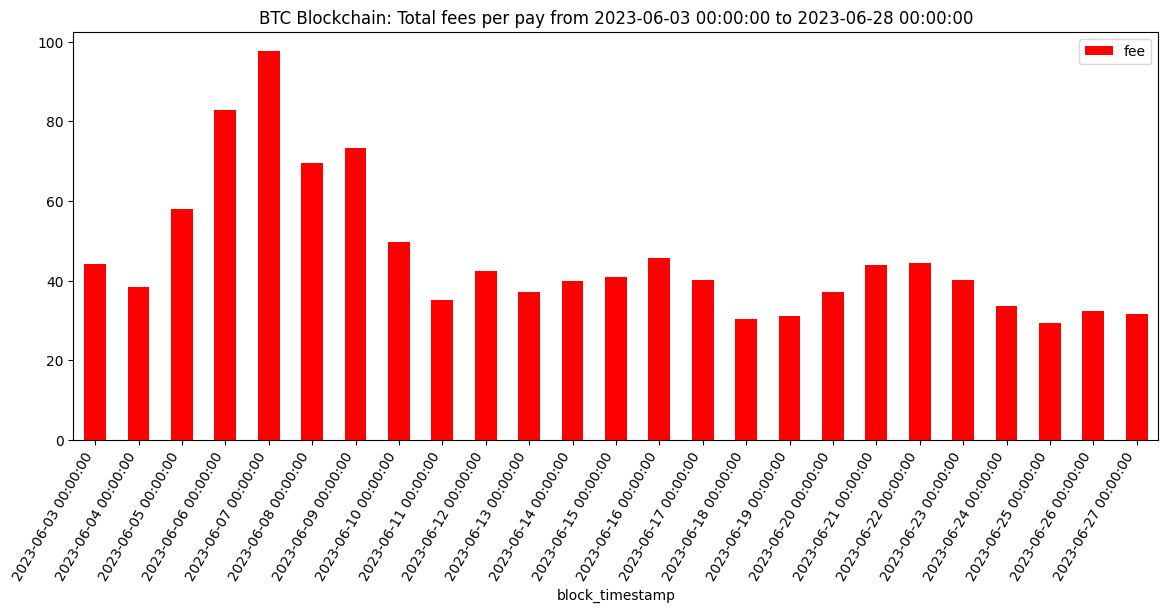

In [13]:
fees_per_day = df.groupby(pd.Grouper(freq='1D')).sum(numeric_only=True)
t = f"BTC Blockchain: Total fees per pay from {plot_start} to {plot_end}"
ax = fees_per_day.plot(kind='bar', y='fee', color='red', figsize=(14, 6), title=t)
ax.figure.autofmt_xdate(rotation=60)

### Conclusions
* We have give a simple recipe for using ArcticDB with AWS for storage
* We have demonstrated that ArcticDB is significantly faster than Parquet files
* We have shown how to read a subset of dates from a symbol of timeseries data
* If we saved a much larger section of the blockchain, it could still be stored in one symbol and subset chunks read efficiently
* Feel free to play around with the notebook to read a larger set of data